# Reconocimiento de Imágenes en CIFAR10

Para experimentar con el reconocimiento de imágenes y la clasificación se estudia el dataset *CIFAR10*, el cual contiene 60.000 imagenes de 32 $\times$ 32 (pixeles), donde cada imagen pertenece a una de las diez clases, clasificación excluyente (gato, perro, rana, caballo, pájaro, ciervo, avión, automóvil, camión y barco). Los datos vienen estructurado en un formato RGB, donde cada imagen (fila del dataset) corresponde a 3072 características, dividido en los 3 canales de RGB (1024 cada uno) correspondiente a cada imagen.  
Los datos vienen separados en datos de entrenamiento y de pruebas, para un estudio eficiente con las técnicas *redes neuronales*, *arboles* y *SVM*, analizando las distintas representaciones de imágenes viendo su efecto.

[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 ..., 
 [ 71  60  74 ...,  68  69  68]
 [250 254 211 ..., 215 255 254]
 [ 62  61  60 ..., 130 130 131]]
min value 0
max value 255


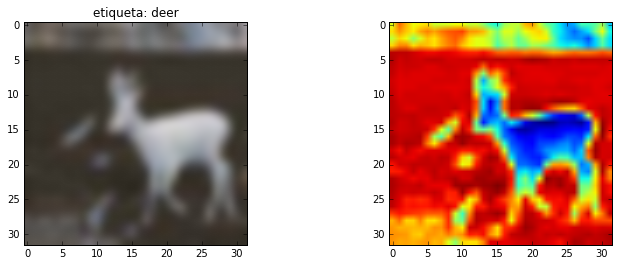

In [70]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

dict1 = unpickle("datasets/data_batch_1")
X = dict1["data"]
print X
Y = dict1['labels']
print "min value" ,min(X[0])
print "max value" ,max(X[0])

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

import numpy as np

def ver_imagen(X,Y,n):
    aux = X[n].copy()

    ima = np.zeros((32,32,3))
    canal_r = np.zeros((32,32))
    j = 0
    i= 0
    for k in range(1024):
        if i < 32:
            canal_r[j,i] = aux[k]
            ima[j,i,0]= aux[k]
            i+=1
        else:
            j+=1
            i = 0
            canal_r[j,i] = aux[k]
            ima[j,i,0]= aux[k]
            i+=1

    canal_g = np.zeros((32,32))
    j = 0
    i= 0
    for k in range(1024,2048):
        if i < 32:
            canal_g[j][i] = aux[k]
            ima[j,i,1]= aux[k]
            i+=1
        else:
            j+=1
            i = 0
            canal_g[j][i] = aux[k]
            ima[j,i,1]= aux[k]
            i+=1

    canal_b = np.zeros((32,32))
    j = 0
    i= 0
    for k in range(2048,3072):
        if i < 32:
            canal_b[j][i] = aux[k]
            ima[j,i,2]= aux[k]
            i+=1
        else:
            j+=1
            i = 0
            canal_b[j][i] = aux[k]
            ima[j,i,2]= aux[k]
            i+=1

    import matplotlib.pyplot as plt
    f,ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].set_title("etiqueta: "+label_names[Y[n]])
    ax[0].imshow(ima, interpolation="bicubic")

    ax[1].imshow(canal_r)
    ax[1].imshow(canal_g)
    ax[1].imshow(canal_b)
    plt.show()
    
ver_imagen(X,Y,20)

Como se ve en lo anterior cada pixel de cada imágen tiene un rango en el que varía, entre 0 y 255, siendo 0 la intensidad mínima del pixel en ese canal y 255 la intensidad máxima

## A)

In [43]:
from scipy.misc import imread
import cPickle as pickle
import numpy as np
import os

def load_CIFAR_one(filename):
    with open(filename, "rb") as f:
        datadict = pickle.load(f)
        X = datadict["data"]
        Y = datadict["labels"]
        return X, np.array(Y)

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, "data_batch_%d" % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, "test_batch"))
    
    #adding Xval
    index = np.arange(np.shape(Xtr)[0]) #filas 
    np.random.shuffle(index) #permutan las filas
    X = Xtr[index, :] #matriz permutada
    Y = Ytr[index]

    #l =  np.random.randint(1000,10000) #entrego 7433
    n = Xtr.shape[0]
    l = 7433
    
    Xval,Xtr = np.split(X,[l])
    Yval,Ytr = np.split(Y,[l])
    
    return Xtr, Ytr, Xte, Yte,Xval,Yval

X_train,Y_train, X_test,Y_test, X_val,Y_val = load_CIFAR10('datasets/')

print 'Training set shape: ',X_train.shape
print 'Validation set shape: ',X_val.shape
print 'Test set shape: ',X_test.shape 

Training set shape:  (42567, 3072)
Validation set shape:  (7433, 3072)
Test set shape:  (10000, 3072)


En primer lugar, se construye una funcion que carga los bloques de entrenamiento, de pruebas y de validacion del dataset en las matrices $X_{train}$, $Y_{train}$, $X_{test}$, $Y_{test}$ y $X_{val}$, $Y_{val}$ respectivamente. El *validation set* es creado a partir del *training set*. Las filas de estas matrices representan cada imagen del dataset, siendo los valores de la fila valores enteros de 0 a 255, que representan los valores de los colores que vienen por los canales *R*,*G* y *B*.

Se puede observar que la matriz $X_{train}$ posee 42567 filas, es decir, 42567 imagenes de entrenamiento. Por otro lado $X_{val}$ posee 7433 imagenes de validación y $X_{test}$ 10000 imágenes de prueba. Las 10 etiquetas están codificadas en números enteros del 0 al 9.  
Es importante destacar que las matrices $X_{train}$ y $X_{val}$ son creadas de manera aleatoria seleccionando las filas permutadas, por lo que cada vez que se ejecute esta celda tendrá distintos resultados en las celdas siguientes, pudiendo no ser exacamente las mismas mediciones de las métricas.

## B) Escalamiento

Datos escalados normalmente


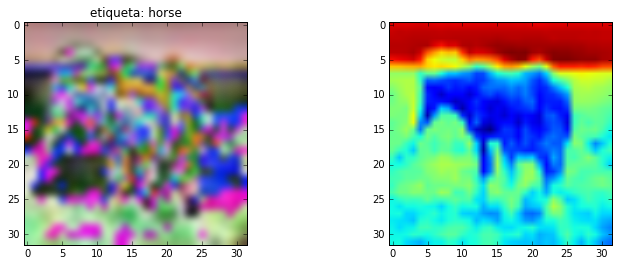

Datos escalados por la intesidad maxima


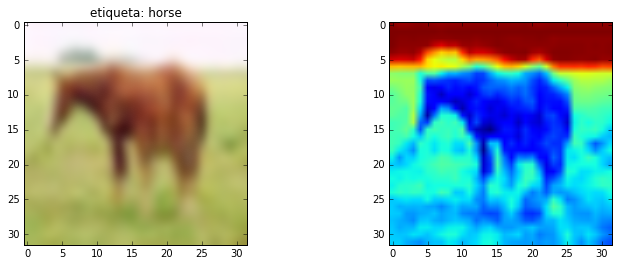

Datos escalados llevados a ceros y unos


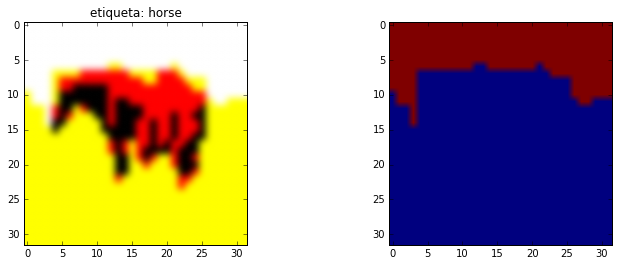

In [74]:
# Escalar y centrar datos
from sklearn.preprocessing import StandardScaler

def scaler_t(X,Xv,Xt,scaler_type):
    if scaler_type == "standar":
        scaler= StandardScaler(with_std=True).fit(X)
        return scaler.transform(X), scaler.transform(Xv), scaler.transform(Xt)
    elif scaler_type == "int_max":
        aux = [ X/255.0, Xv/255.0, Xt/255.0 ]
        newX = aux[0].copy()
        newXv = aux[1].copy()
        newXt = aux[2].copy()
        return newX,newXv,newXt
    elif scaler_type == "zeros_ones":
        newX = X.copy()
        newXv = Xv.copy()
        newXt = Xt.copy()
        newX[ newX <128] = 0
        newX[ newX > 127] = 1
        newXv[ newXv <128] = 0
        newXv[ newXv > 127] = 1
        newXt[ newXt < 128] = 0
        newXt[ newXt > 127] = 1
        return newX,newXv,newXt
    else: #otro
        return X*0.5
    
print "Datos escalados normalmente"
X,Xv,Xt = scaler_t(X_train,X_val,X_test,"standar")
ver_imagen(X,Y_train,30)

print "Datos escalados por la intesidad maxima"
X,Xv,Xt = scaler_t(X_train,X_val,X_test,"int_max")
ver_imagen(X,Y_train,30)

print "Datos escalados llevados a ceros y unos"
X,Xv,Xt = scaler_t(X_train,X_val,X_test,"zeros_ones")
ver_imagen(X,Y_train,30)

En esta celda se escalan las imágenes, para poder trabajarlas de forma apropiada. Este escalamiento se realiza en base a la intensidad maxima de los pixeles de las imágenes, siendo el 0 la intensidad mínima y el 1 la intensidad máxima (255), estandarizando los datos normalmente o una representación basada en ceros y unos, donde los ceros corresponden a los pixeles bajos y los unos a los pixeles mas altos. Mostrándo las imágenes en su escalamiento para ver visualmente como varían, a la izquierda es la imagen escalada y a la derecha es la imagen con los canales RGB sobrepuestos.

## C) ANN - analisis

In [7]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.optimizers import SGD,RMSprop


Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"standar")
Ytr = to_categorical(Y_train)
Yv = to_categorical(Y_val)
Yt = to_categorical(Y_test)
print "Para representacion datos normalizados estandar"

#experimentar variando valores
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.05), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xv, Yv)
print "\nVALIDATION ACCURACY (activation relu-softmax) = %f"% scores[1]

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.05), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xv, Yv)
print "\nVALIDATION ACCURACY (activation relu-sigmoid) = %f"% scores[1]

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xv, Yv)
print "\nVALIDATION ACCURACY (optimizer RMSprop and activation relu-sigmoid) = %f"% scores[1]

print "------------------------------------------------"

Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"int_max")
Ytr = to_categorical(Y_train)
Yv = to_categorical(Y_val)
Yt = to_categorical(Y_test)
print "Para representacion datos escalados por la intensidad maxima (0-255 pasa a 0-1)"

#experimentar variando valores
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.05), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xv, Yv)
print "\nVALIDATION ACCURACY (activation relu-softmax) = %f"% scores[1]

#experimentar variando valores
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.05), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xv, Yv)
print "\nVALIDATION ACCURACY (activation relu-sigmoid)= %f"% scores[1]

print "------------------------------------------------"
Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"zeros_ones")
Ytr = to_categorical(Y_train)
Yv = to_categorical(Y_val)
Yt = to_categorical(Y_test)
print "Para representacion datos escalados llevados a 0 o 1(0-127 pasa a 0 y 128-255 pasa a 1)"

#experimentar variando valores
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.05), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xv, Yv)
print "\nVALIDATION ACCURACY (activation relu-softmax) = %f"% scores[1]

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xv, Yv)
print "\nVALIDATION ACCURACY (activation relu-softmax) loss categorical = %f"% scores[1]

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=1), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xv, Yv)
print "\nVALIDATION ACCURACY (activation relu-softmax) l=1  = %f"% scores[1]

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.05), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xv, Yv)
print "\nVALIDATION ACCURACY (activation relu-sigmoid)= %f"% scores[1]

Para representacion datos normalizados estandar
7433/7433 [==============================] - 0s     

VALIDATION ACCURACY (activation relu-softmax) = 0.914933
7360/7433 [============================>.] - ETA: 0s
VALIDATION ACCURACY (activation relu-sigmoid) = 0.917839
7392/7433 [============================>.] - ETA: 0s
VALIDATION ACCURACY (optimizer RMSprop and activation relu-sigmoid) = 0.908772
------------------------------------------------
Para representacion datos escalados por la intensidad maxima (0-255 pasa a 0-1)
7433/7433 [==============================] - 0s     

VALIDATION ACCURACY (activation relu-softmax) = 0.917476
7232/7433 [============================>.] - ETA: 0s
VALIDATION ACCURACY (activation relu-sigmoid)= 0.915552
------------------------------------------------
Para representacion datos escalados llevados a 0 o 1(0-127 pasa a 0 y 128-255 pasa a 1)
7360/7433 [============================>.] - ETA: 0s
VALIDATION ACCURACY (activation relu-softmax) = 0.902502
716

En la celda anterior se ajusta una red neuronal con distintas arquitecturas para distintos escalamiento de los datos, midiendo el score (*accuracy*) sobre el *validation set* logrando decidir que la mejor configuración es la de usar funciones de activaciones "relu" y "sigmoid" para las 2 capas que posee, con la representación RGB de los datos normalizados de manera estándar. A continuación se presenta el efecto de esta configuración sobre el *test set*.

In [56]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.optimizers import SGD,RMSprop

Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"standar")
Ytr = to_categorical(Y_train)
Yv = to_categorical(Y_val)
Yt = to_categorical(Y_test)
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xt, Yt)
print "\nTEST ACCURACY (activation relu-sigmoid) = %f"% scores[1]

 9920/10000 [============================>.] - ETA: 0s
TEST ACCURACY (activation relu-sigmoid) = 0.915720


Para la configuración descrita anteriormente se logra este *accuracy* de **91,57%**, el cual presenta un error del **8.43%**. Este error es bastante más bajo y mejor de lo que se esperaba (50%), logrando un desempeño muy bueno para la red neuronal con la representación en pixeles RGB de los datos, escalados normalmente.

## D) Cambio de Representación

In [55]:
from top_level_features import hog_features
from top_level_features import color_histogram_hsv
from top_level_features import extract_features
X_train, Y_train, X_test, Y_test,X_val,Y_val = load_CIFAR10("datasets/")
print "dimensiones de conjunto de entrenamiento ", X_train.shape

features = extract_features(X_train,[hog_features],verbose=0) #extrae hog features
print 'Dimensiones de representacion segun histograma de gradientes: ',features.shape
features = extract_features(X_train,[color_histogram_hsv]) #extrae histogramas de color
print 'Dimensiones de representacion segun histogramas de color: ',features.shape
features = extract_features(X_train,[hog_features, color_histogram_hsv]) #extrae todo
print 'Dimensiones de representacion mixta: ' ,features.shape

dimensiones de conjunto de entrenamiento  (42567, 3072)
(42567, 32, 32, 3)
Dimensiones de representacion segun histograma de gradientes:  (42567, 144)
(42567, 32, 32, 3)
Dimensiones de representacion segun histogramas de color:  (42567, 10)
(42567, 32, 32, 3)
Dimensiones de representacion mixta:  (42567, 154)


Para la celda anterior se mejoran los atributos cambiando la representación orientado al cambio de dimensionalidad. Este cambio dimensional se produce por la extraccion de caracteristicas de cada representacion, en este caso esa extraccion se interpreta como la frecuencia de ciertos colores en el caso de los histogramas de color y las direcciones del gradiente en el caso de los histogramas de gradientes.
Se puede observar que el numero de columnas para la representación segun *histograma de gradientes* es de 144, lo que quiere decir que esta representación extrae 144 caracteristicas que simbolizan las direcciones del gradiente, valores que tienen un rango entre 0 y 1.

Para el caso de la representacion segun *histogramas de color* el numero de columnas es de 10, lo que quiere decir que esta representación extrae 10 caracteristicas que simbolizan las frecuencias de los colores, valores que tienen un rango variable.
Y por ultimo, la representacion mixta que posee 154 columnas, que simbolizan las direcciones del gradiente y las frecuencias de colores, siendo esta representacion la concatenacion de las dos anteriores.

En la celda anterior y en la siguiente se cambia la representación de los datos en base a características mas de alto nivel como lo son los histogramas de gradientes, donde se ven las direcciones de la forma de la figura en la imagen, los histogramas de color, basado en los distintos tonos de colores presentes en la imagen y finalmente, una representación mixta de ambas representaciones.

In [53]:
def representacion(x,xv,xt,tipo):
    if tipo=="hog":
        features_train = extract_features(x,[hog_features]) #extrae hog features
        features_val = extract_features(xv,[hog_features]) #extrae hog features
        features_test = extract_features(xt,[hog_features]) #extrae hog features
    elif tipo=="histogram":
        features_train = extract_features(x,[color_histogram_hsv]) #extrae histogramas de color
        features_val = extract_features(xv,[color_histogram_hsv]) #extrae histogramas de color
        features_test = extract_features(xt,[color_histogram_hsv]) #extraehistogramas de color
    else:
        features_train = extract_features(x,[hog_features, color_histogram_hsv]) #extrae todo
        features_val = extract_features(xv,[hog_features, color_histogram_hsv]) #extrae todo
        features_test = extract_features(xt,[hog_features, color_histogram_hsv]) #extrae todo

    return features_train,features_val,features_test

In [53]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.optimizers import SGD,RMSprop

Ytr = to_categorical(Y_train)
Yv = to_categorical(Y_val)
Yt = to_categorical(Y_test)

Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"hog")

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xv, Yv)
print "\nVALIDATION ACCURACY (activation relu-softmax) in HOG = %f"% scores[1]

Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"histogram")

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xv, Yv)
print "\nVALIDATION ACCURACY (activation relu-softmax) in COLOR HISTOGRAM = %f"% scores[1]

Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"combinados")

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xv, Yv)
print "\nVALIDATION ACCURACY (activation relu-softmax) in COMBINED = %f"% scores[1]

(42567, 32, 32, 3)
(7433, 32, 32, 3)
(10000, 32, 32, 3)
6912/7433 [==========================>...] - ETA: 0s
VALIDATION ACCURACY (activation relu-softmax) in HOG = 0.919709
(42567, 32, 32, 3)
(7433, 32, 32, 3)
(10000, 32, 32, 3)
6624/7433 [=========================>....] - ETA: 0s
VALIDATION ACCURACY (activation relu-softmax) in COLOR HISTOGRAM = 0.900000
(42567, 32, 32, 3)
(7433, 32, 32, 3)
(10000, 32, 32, 3)
7392/7433 [============================>.] - ETA: 0s
VALIDATION ACCURACY (activation relu-softmax) in COMBINED = 0.921243


En la celda anterior se ve el efecto de las representaciones de alto nivel implementadas las cuales entregan una mejora en el score *accuracy*. Siendo la mejor representación según el score en el *validation set* la combinada, es decir incluyendo las características de los histogramas de color (tono) y gradiente. Presentando su evaluación sobre el *test set* a continuación.

In [52]:
Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"combinados")
Ytr = to_categorical(Y_train)
Yt = to_categorical(Y_test)
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xt, Yt)
print "\nTest ACCURACY (activation relu-softmax) in COMBINED = %f"% scores[1]

(42567, 32, 32, 3)
(7433, 32, 32, 3)
(10000, 32, 32, 3)
 9376/10000 [===========================>..] - ETA: 0s
Test ACCURACY (activation relu-softmax) in COMBINED = 0.920780


Se presenta un score del **92,08%** sobre el *test set* para esta representación, es decir, un error del **7.92%**, mejorando este score respecto a la representación basada en RGB, levemente en un 0.5%. Esto es lo esperado para estas representaciones de alto nivel las cuales para este caso entregan más información significativa a la red neuronal para hacer la predicción sobre la etiqueta del dato en cada caso.

## E) SVM no lineal

In [ ]:
from sklearn.svm import SVC

Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"standar")

clf = SVC(C=1, kernel="rbf")        
clf = clf.fit(Xtr,Y_train)  
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH STANDAR NORMALIZE = %f"% acc

VALIDATION ACCURACY WITH STANDAR NORMALIZE = 0.538006


Para el caso de ajustar un clasificador SVM, resulta bastante costoso en tiempo, por lo que se presenta un solo resultado el cual fue posible rescatar ejecutando por 3 horas una *SVM* no lineal con kernel "RBF" con la representación estandarizada normalmente de los datos. Un *accuracy* de **53,8%** asociado a un error del **46,2%**, valor mucho peor que el de una red neuronal de 2 capas, por lo que en base a esta medicion y el tiempo de ejecución, se concluye que *SVM* para esta clasificación de un gran número de imágenes no es recomendado.

In [ ]:
Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"histogram")

clf = SVC(C=1, kernel="rbf",verbose=1)        
clf = clf.fit(Xtr,Y_train)  
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH HOG = %f"% acc

## F) Árbol de Clasificación

In [57]:
from sklearn.tree import DecisionTreeClassifier as Tree

N_ts = [2,5,10,13,17,20,25,30,50,80,90,100,150]
def do_Tree(x,y,xv,yv):
    mejor = 0
    nivel = 0
    info = []
    for n_t in N_ts:
        print "arbol: %d"%n_t
        clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=n_t)
        clf.fit(x,y)
        acc = clf.score(x,y)
        acc_v = clf.score(xv,yv)
        if acc_v > mejor:
            mejor = acc_v
            nivel = n_t
        info.append([acc,acc_v])
    print "Best Validation Accuracy = %f"%mejor
    print "Tree's Level = %f"%nivel
    return info

In [58]:
Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"standar")

#cuidado---se demora harto
info1 = do_Tree(Xtr,Y_train,Xv,Y_val)

arbol: 2
arbol: 5
arbol: 10
arbol: 13
arbol: 17
arbol: 20
arbol: 25
arbol: 30
arbol: 50
arbol: 80
arbol: 90
arbol: 100
arbol: 150
Best Validation Accuracy = 0.287905
Tree's Level = 10.000000


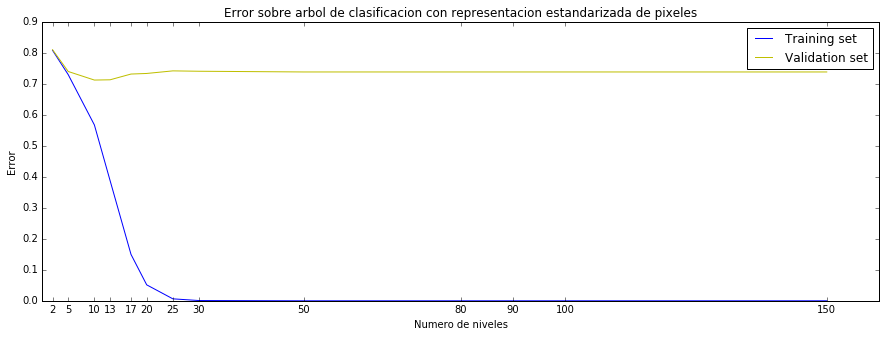

In [61]:
#utilizar el info
error1 = [1-i[0] for i in info1]
error2 = [1-i[1] for i in info1]
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(N_ts,error1, label = "Training set", color = "b")
plt.plot(N_ts,error2, label = "Validation set", color = "y")
plt.xticks(N_ts)
plt.xlabel('Numero de niveles')
plt.ylabel('Error')
plt.title('Error sobre arbol de clasificacion con representacion estandarizada de pixeles')
plt.legend(loc="upper right")
plt.show()

En esta sección se entrena una SVM no lineal sobre los pixeles originales y sobre los atributos de alto nivel generados en las secciones anteriores, las cuales son *int_max*: estandarización en el rango entre 0 y 1 y *zeros_ones*: representación en base a solo valores 0 o 1.

En primer lugar, con un modelo de árbol, se obtiene que la profundidad más optima en el rango de 2 y 150 niveles, es la de 10 niveles, llegando a un *accuracy* máximo del *29.4%*, el cual es bastante inferior a los obtenidos anteriormente con el modelo de redes neuronales.
Luego, se confecciona un gráfico de error versus número de niveles del modelo de árbol, en el cual se utiliza una estandarización normal y con kernel Gaussiano *rbf*.  
Se puede observar del gráfico que el error del training set comienza en un valor del *80%* para un número de dos niveles de profundidad, valor que es bastante alto, pero que a medida que se aumenta el numero de niveles se va reduciendo bruscamente hasta llegar a un error de valor cercano a 0 en niveles superiores a 30. Esto claramente representa un *overffiting* de parte del modelo, ya que se ajusta demasiado a la data de entrenamiento, lo que produce un bajo rendimiento en el *validation set*, el cual posee un error constante del *70%* aproximadamente que se mantiene desde niveles superiores a 5 de profundidad.

A continuación se prueba sobre el *validation set* los distintos tipos de escalamientos para el árbol de clasificación con 10 niveles.

In [60]:
Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"int_max")

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=10)
clf.fit(Xtr,Y_train)
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH NORMALIZE BETWEEN 0-1 = %f"% acc
        
#info2 = do_Tree(Xtr,Ytr,Xv,Yv)

VALIDATION ACCURACY WITH NORMALIZE BETWEEN 0-1 = 0.287636


In [10]:
Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"zeros_ones")

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=10)
clf.fit(Xtr,Y_train)
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH 0's and 1's REPRESENTATION = %f"% acc

#info3 = do_Tree(Xtr,Ytr,Xv,Yv)

VALIDATION ACCURACY WITH 0's and 1's REPRESENTATION = 0.286291


Se puede observar que el tipo de escalamiento que tiene mejor *accuracy* sobre el validation set es la de *int_max*, en la cual los valores varian en un rango de 0 hasta 1. Obteniendose un *accuracy* maximo del *29.4%*, el cual es *1%* mejor que con el escalamiento con solo ceros y unos.

A continuación se prueban las distintas representaciones de extracción de características

In [11]:
Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"hog")

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth = 10)
clf.fit(Xtr,Y_train)
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH HOG REPRESENTATION = %f"% acc

#info4 = do_Tree(Xtr,Ytr,Xv,Yv)

(42567, 32, 32, 3)
(7433, 32, 32, 3)
(10000, 32, 32, 3)
VALIDATION ACCURACY WITH HOG REPRESENTATION = 0.288982


In [12]:
Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"histogram")

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=10)
clf.fit(Xtr,Y_train)
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH COLOR HISTOGRAM REPRESENTATION = %f"% acc

#info5 = do_Tree(Xtr,Ytr,Xv,Yv)

(42567, 32, 32, 3)
(7433, 32, 32, 3)
(10000, 32, 32, 3)
VALIDATION ACCURACY WITH COLOR HISTOGRAM REPRESENTATION = 0.256155


In [ ]:
Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"combinacion")

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=10)
clf.fit(Xtr,Y_train)
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH COLOR HISTOGRAM AND HOG REPRESENTATION = %f"% acc

(42567, 32, 32, 3)
(7433, 32, 32, 3)
(10000, 32, 32, 3)
VALIDATION ACCURACY WITH COLOR HISTOGRAM AND HOG REPRESENTATION = 0.307682


En las celdas anteriores se pueden obervar que claramente la representacion mixta entre los histogramas de color y la de gradientes (HOG) posee un mejor valor de *accuracy* que ambas representaciones por separado, obteniendose un valor maximo del *30%*, el cual nuevamente es bastante bajo comparado con los resultados obtenidos anteriormente con los modelos de redes neuronales. 

En base a lo anteriormente experimentado se escogen los mejores hiperparámetros y representación para un árbol de clasificación para este problema de clasificación de imágenes, la cual es la combinación de las características de alto nivel de histogramas de color y gradiantes. Mostrándo a continuación el error sobre el test set.

In [56]:
from sklearn.tree import DecisionTreeClassifier as Tree
#la mejor representacion = combinacion
#el mejor nivel = 10
Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"combinacion")

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=10)
clf.fit(Xtr,Y_train)
acc = clf.score(Xt,Y_test)
print "TEST ACCURACY WITH COLOR HISTOGRAM AND HOG REPRESENTATION = %f"% acc

(42567, 32, 32, 3)
(7433, 32, 32, 3)
(10000, 32, 32, 3)
TEST ACCURACY WITH COLOR HISTOGRAM AND HOG REPRESENTATION = 0.314300


Para esta representación elegida evaluada con el *score* sobre el *test set* se encuentra un valor de **31,4%**, asociado con un error de **68.6**. Se puede ver que este error es mucho mayor que para una red neuronal con 2 capas, esto muestra el gran poder que tiene una neurona para clasificar imágenes y lo difícil que se torna para un árbol de clasificación, ya que con distintas representaciones y distintos escalamientos no se logre un mejor desempeño. 